This is the Jupyter notebook used to analyze months of retweets from federal candidates in the 2019 Canadian
general election. The goal was to measure how much candidates were amplifying disinformation and malicious Twitter bots
by running each retweed user through the Botometer API to fetch their bot score.

A bot score of 3 or more is a suspect automated account.

This analysis [led to this story](https://www.cbc.ca/news/politics/twitter-candidates-retweets-1.5335220).

### Data prep

In [1]:
# Connect to MySQL database where retweets and bot scores are stored. The DB has two tables:

# retweets: All retweets from federal candidates that are scraped nightly using the Twitter API
# botometer_scores: The bot scores of every unique Twitter account that is retweeted by candidates.
# Bot scores are refreshed once a week.

import pandas as pd
import MySQLdb
import os
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# Login from using environment variables
db_login = dict(host = os.environ['db_host'],
        database = os.environ['db_name'],
        user = os.environ['db_user'],
        password = os.environ['db_pass'])

db = MySQLdb.connect(**db_login)
df = pd.read_sql('select * from retweets;', con=db)
# Drop duplicate tweet_ids in case of duplication
df = df.drop_duplicates('tweet_id')
# Lowercase user handles
df['user_handle_norm'] = df.user_handle.str.lower()
df['rt_user_screen_name_norm'] = df.rt_user_screen_name.str.lower()
# Convert tweet time to EST
df['created_at'] = pd.to_datetime(df.created_at).dt.tz_convert('US/Eastern')

bots = pd.read_sql('select * from botometer_scores;', con=db)

db.close()

df.head()

,row_id,user_id,user_name,user_handle,created_at,tweet_id,text,retweet_count,favorite_count,rt_created_at,...,rt_user_name,rt_user_screen_name,rt_user_location,rt_user_description,rt_user_followers_count,rt_user_statuses_count,rt_user_lang,retweet_type,user_handle_norm,rt_user_screen_name_norm
0,1061,1084856644687679496,Scot Davidson,ScotDavidsonMP,2019-05-14 13:53:56-04:00,1128357792862044161,RT @YRP: Newborn baby boy was left outside of ...,169,0,Tue May 14 12:32:56 +0000 2019,...,York Regional Police,YRP,"Aurora, Ontario",York Regional Police Official Twitter. In case...,156778,22561,en,retweeted,scotdavidsonmp,yrp
1,1062,1084856644687679496,Scot Davidson,ScotDavidsonMP,2019-05-06 12:11:45-04:00,1125432976983175169,"RT @AndrewScheer: Over the next several weeks,...",548,0,Mon May 06 14:51:06 +0000 2019,...,Andrew Scheer,AndrewScheer,Canada,Leader of Canadas Conservatives and Leader of...,143845,11001,en,retweeted,scotdavidsonmp,andrewscheer
2,1063,1084856644687679496,Scot Davidson,ScotDavidsonMP,2019-05-01 16:11:31-04:00,1123681375121485824,"RT @CPC_HQ: Once again, Liberals are asking Ca...",221,0,Wed May 01 11:10:00 +0000 2019,...,Conservative Party,CPC_HQ,Canada,"Canadas Official Opposition, led by @AndrewSc...",156203,10222,en,retweeted,scotdavidsonmp,cpc_hq
3,1064,1084856644687679496,Scot Davidson,ScotDavidsonMP,2019-04-02 16:31:57-04:00,1113177270846455810,RT @YRPAca: Great to meet with our local #York...,3,0,Tue Apr 02 19:49:41 +0000 2019,...,York Regional Police Association,YRPAca,"Newmarket, Ontario",York Regional Police Association (YRPA) is a l...,321,213,en,retweeted,scotdavidsonmp,yrpaca
4,1065,1084856644687679496,Scot Davidson,ScotDavidsonMP,2019-03-15 11:43:53-04:00,1106581792042049537,Our hearts here in riding of York Simcoe and a...,0,5,Fri Mar 15 03:08:36 +0000 2019,...,Andrew Scheer,AndrewScheer,Canada,Leader of Canadas Conservatives and Leader of...,143845,11001,en,quoted,scotdavidsonmp,andrewscheer


In [3]:
# Exclude tweets after election. We are only interested in the campaign period.

df = df[df.created_at <= '2019-10-21']

In [3]:
# Number of retweets in db

len(df)

306035

In [4]:
# Earliest retweet in the database

df.created_at.min()

Timestamp('2011-03-14 00:25:29-0400', tz='US/Eastern')

In [40]:
# Number of unique Twitter accounts monitored

len(df.user_id.unique())

1186

In [6]:
# Load CSV with candidate names and parties to join to retweet data 

handles = pd.read_csv('candidate_twitter_handles.csv')
handles.twitter_handle = handles.twitter_handle.str.lower()
df = df.merge(handles[['twitter_handle', 'party']], left_on = 'user_handle_norm', 
              right_on = 'twitter_handle', how = 'left')

In [7]:
# Also join political party to retweeted accounts to see how often parties retweet each other
# This involved making a dictionary of Twitter handle and party and mapping to the retweeted user name

party_map = handles[['twitter_handle', 'party']].set_index('twitter_handle').to_dict()['party']

df['rt_user_party'] = df.rt_user_screen_name_norm.map(party_map)
df[['party_str','rt_user_party_str']] = df[['party', 'rt_user_party']].astype(str)

### Retweet analysis

In [12]:
# Number of candidates per party

df.drop_duplicates('user_handle_norm').groupby('party').size()

party
Bloc             29
Conservative    249
Green           124
Liberal         266
NDP             174
PPC             251
dtype: int64

In [7]:
# Candidates that retweeted the most

df.user_handle.value_counts().head(20)

ElizabethMay       7154
SusannarussoP      6852
RobLussier         3718
Carolyn_Bennett    3236
PpcYukon           2782
MaximeBernier      2752
TOAdamVaughan      2443
BonnieNorthGP      2419
MarkParalovos      2405
GP_EtobCen         2353
cathmckenna        2263
JennyKwanBC        2141
VoteAnnieYoung     1854
ArcadiaNancy       1756
ValTremblay_Sag    1745
jimcarr_wpg        1676
AlbertaPpc         1607
MarcDalton         1531
thereds8           1506
JIGNAJANI_PPC      1479
Name: user_handle, dtype: int64

In [8]:
# Accounts that were retweeted the most

df.rt_user_screen_name.value_counts().head(20)

MaximeBernier      12987
JustinTrudeau      11865
AndrewScheer       10655
CPC_HQ              3809
theJagmeetSingh     3385
liberal_party       3353
CanadianGreens      2463
cathmckenna         1939
NDP                 1642
ElizabethMay        1565
parti_liberal       1387
yfblanchet          1250
BlocQuebecois       1134
MarkFriesen08       1118
FPVaughanIII        1071
tylermeredith       1022
jyduclos             995
davidakin            974
PierrePoilievre      908
melaniejoly          870
Name: rt_user_screen_name, dtype: int64

In [9]:
# How much candidates retweeted other parties
# Group by user party and retweeted party

other_party_retweets = df.groupby(['party', 'rt_user_party']).size().unstack()
other_party_retweets.sort_index(ascending = False, inplace = True)
#other_party_retweets.to_clipboard()

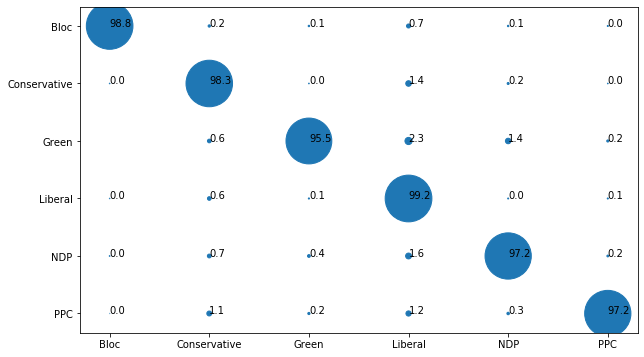

In [98]:
import matplotlib.pyplot as plt

# Visualize inter-party retweets as a cross-tab bubble chart

# Reshape data into rows and columns for parties
other_party_retweets_stack = other_party_retweets.stack().reset_index(name='retweets')

# Calculate a bubble size by retweet count
other_party_retweets_stack['bubble_size'] = other_party_retweets_stack.retweets * 22

# Use a scatter plot with labeled bubbles using the parties as the categorical axes
plt.figure(figsize=(10,6))
plt.scatter(x='rt_user_party', y='party', s='bubble_size', data=other_party_retweets_stack)
# Label bubbles with the percentage of retweets from party to party
for i, txt in enumerate(other_party_retweets_stack.retweets):
     plt.annotate('{:.1f}'.format(txt), (other_party_retweets_stack.rt_user_party[i], other_party_retweets_stack.party[i]))

plt.savefig('candidate_party_rts.svg')

In [ ]:
# How often party leaders retweet each other

# Isolate leader accounts
leaders = ['justintrudeau', 'maximebernier', 'andrewscheer', 'thejagmeetsingh', 'elizabethmay', 'yfblanchet']

crosstalk = df[(df.user_handle_norm.isin(leaders)) 
               & (df.rt_user_screen_name_norm.isin(leaders)) 
               & (df.user_handle_norm != df.rt_user_screen_name_norm)]

In [11]:
# How much leaders RT'd other leaders

crosstalk.groupby(['user_handle', 'rt_user_screen_name']).size().unstack()

rt_user_screen_name,AndrewScheer,ElizabethMay,JustinTrudeau,theJagmeetSingh,yfblanchet
user_handle,,,,,
AndrewScheer,nan,nan,2.0,nan,nan
ElizabethMay,nan,nan,1.0,nan,nan
MaximeBernier,25.0,7.0,8.0,7.0,nan
theJagmeetSingh,nan,nan,4.0,nan,1.0
yfblanchet,nan,2.0,nan,1.0,nan


In [49]:
# Most candidates just retweet the party leader or the official party account
# Find those who don't

parties = ['cpc_hq', 'pcc_hq', 'liberal_party', 'ndp', 'canadiangreens', 'pmcanadien']

non_party_retweets = (df.groupby(['user_handle_norm', 'party', 'rt_user_screen_name_norm'])
 .size()
 .reset_index(name='retweets')
 .sort_values(['user_handle_norm', 'retweets'], ascending = [1,0])
 .groupby('user_handle_norm')
 .head(3)
 .query('rt_user_screen_name_norm not in @leaders and rt_user_screen_name_norm not in @parties')
)

# Number of out-of-party retweets by party
non_party_retweets.party.value_counts()

PPC             509
Liberal         458
Conservative    370
NDP             303
Green           188
Bloc             62
Name: party, dtype: int64

In [19]:
# Count retweets of major Canadian news accounts

# Isolate news accounts using regex filtering
news_kw = "news|post millennial|nouvelles|presse|devoir|north99|times\
           |globe and mail|national post|torontostar|power & politics|magazine|rebel|sun"

news_rts = df[df.rt_user_name.str.contains(news_kw, case = False)]
news_rts.rt_user_name.value_counts().head(25)

National Post                    506
Power & Politics                 440
CBC News                         430
TorontoStar                      398
CTV News                         389
CBC News Alerts                  366
National Newswatch               331
Maclean's Magazine               313
Globalnews.ca                    279
The Globe and Mail               265
The Post Millennial              210
TVA nouvelles                    160
GC Newsroom                      139
La Presse                        121
The Rebel                        110
Toronto Sun                      106
Galerie de presse PLC            100
APTN National News                82
Rebel News                        67
CBC News: The National            62
CityNews Toronto                  61
GC Salle de Presse                61
Le Devoir                         52
myFM News                         42
??Laurentian News Service????     39
Name: rt_user_name, dtype: int64

In [20]:
# 10 most retweet news accounts for each party

(news_rts.groupby(['party', 'rt_user_name']).size()
 .reset_index(name='retweets')
 .sort_values(['party', 'retweets'], ascending = [1,0])
 .groupby('party')
 .head(10)
)

,party,rt_user_name,retweets
3,Bloc,La Presse,14
10,Bloc,TVA nouvelles,14
5,Bloc,Le Devoir,8
4,Bloc,La Presse canadienne,4
8,Bloc,Power & Politics,3
7,Bloc,Magazine L'actualité,2
0,Bloc,ABC News,1
1,Bloc,Breaking News Feed,1
2,Bloc,CNEWS,1
6,Bloc,LesNews,1


### Bot score analysis

In [21]:
# Join retweet data with botometer scores for retweeted accounts

merged = df.merge(bots, left_on='rt_user_id', right_on='user_id')
len(merged)

291211

In [22]:
# Sort joined table by bot score. Which retweeted accounts have the highest scores?

merged.sort_values('bot_score', ascending=False)[['user_name', 'user_handle_x', 'text', 'rt_user_id', 'rt_user_name', 'rt_user_screen_name', 'bot_score']]

,user_name,user_handle_x,text,rt_user_id,rt_user_name,rt_user_screen_name,bot_score
285931,Billie Cross,BillieCrossNDP,RT @RajforRadisson: https://t.co/rrAwYw2D72,1124428682557382658,Raj Sandhu,RajforRadisson,4.9
151571,Jody Wilson-Raybould,Puglaas,RT @VanGranEDA: The Vancouver Granville Libera...,1102455892891426816,Vancouver Granville Electoral District Associa...,VanGranEDA,4.9
282910,Kingsley Kwok ???,KingsleyKwok,RT @clcyorkregion: Did we get your attention t...,1151577895762087937,Community Legal Clinic of York Region,clcyorkregion,4.9
251350,Claire Card,ClaireCard,This is one time when follow the leader is r...,897617380536442881,Jenny Selsby,JennySelsby,4.9
271763,Nick Whalen,NickWhalenMP,Did I just see a cyclist in the TCH near CBS? ...,902245735021858820,Sarah Noble,sarahno1111,4.9
55129,Guy Lauzon,GuyLauzonMP,My Conservative colleagues @AliceWongCanada an...,271343342,Alice Wong,AliceWongCanada,4.8
170190,Joël Lightbound,JoelLightbound,RT @RSouvenirr: L'équité intergénérationnelle ...,840302396840542209,Ricardo Souvenir,RSouvenirr,4.8
271428,Peter Julian,MPJulian,"Yes, Diane- we are absolutely on it! https://t...",876579612318285824,Diane Wood,woodhaus33,4.8
210201,Michelle Rempel Garner,MichelleRempel,Those...are fighting words! https://t.co/gK6i3...,893702767532924928,Patti Huseby,phuseby4,4.8
256395,Andrew Cash,AndrewCash,RT @JeremyGWithers: Thanks @TorontoStar and @T...,933832818475507712,Jeremy Withers,JeremyGWithers,4.8


In [23]:
# Bot score summary stats per party. Sort by mean bot score.

merged.groupby('party').describe().bot_score.sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
party,,,,,,,,
PPC,75246.0,0.8,0.6,0.1,0.4,0.5,1.0,4.8
Green,32528.0,0.7,0.7,0.1,0.3,0.4,0.8,4.8
NDP,33624.0,0.6,0.6,0.1,0.2,0.4,0.7,4.9
Liberal,74831.0,0.5,0.5,0.1,0.2,0.3,0.6,4.9
Conservative,45409.0,0.5,0.5,0.1,0.2,0.4,0.5,4.8
Bloc,5692.0,0.4,0.5,0.1,0.2,0.2,0.4,4.7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D46650A58>,
      dtype=object)

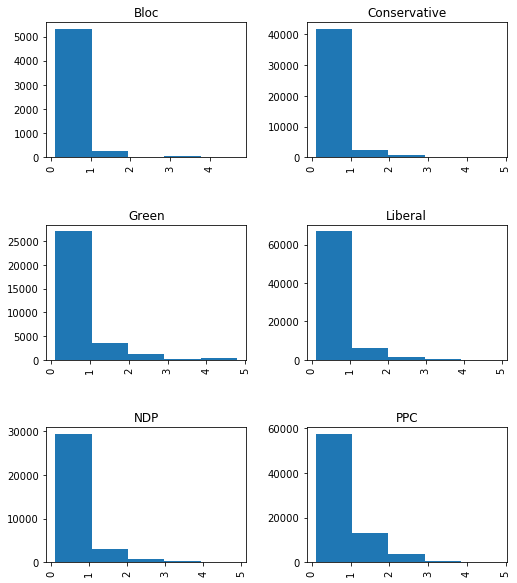

In [24]:
# Plot a histogram of bot cores for each party

merged.hist('bot_score', by = 'party', bins = 5, figsize = (8, 10))

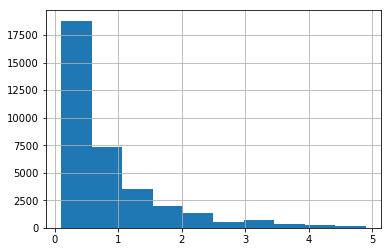

In [28]:
# Histogram of all bot scores

bots.bot_score.hist()

In [25]:
# 10 most retweeted accounts by party

(merged.groupby(['party', 'rt_user_screen_name']).size()
  .reset_index(name='rts')
  .sort_values(['party', 'rts'], ascending = [1,0])
  .groupby('party')
  .head(10)
)

,party,rt_user_screen_name,rts
868,Bloc,yfblanchet,1200
59,Bloc,BlocQuebecois,1076
506,Bloc,ValTremblay_Sag,152
252,Bloc,JulieVignolaBQ,104
730,Bloc,m_pauze,87
68,Bloc,CHebertQc,84
216,Bloc,JFLisee,76
764,Bloc,mimivoy,73
695,Bloc,julie_marceau,59
818,Bloc,sbergeron,53


In [27]:
# Bot score summary stats by candidates. Which candidates retweed the most
# high-bot-score accounts? Keep only accounts that retweeted at least 20 times.

high_bot_avgs = (merged.groupby('user_handle_x').bot_score.describe()
                 .sort_values('mean', ascending = False)
                 .query('count >= 20') )
high_bot_avgs.head(20)

,count,mean,std,min,25%,50%,75%,max
user_handle_x,,,,,,,,
nicki_ward,139.0,2.2,0.7,0.2,2.5,2.5,2.5,2.5
DavidMicalef,29.0,2.1,1.5,0.2,0.7,1.9,3.9,3.9
PL_GreenParty,48.0,1.9,2.0,0.1,0.3,0.3,4.4,4.4
geoffregan,64.0,1.8,1.1,0.2,0.6,2.3,2.7,3.4
Azmairnin2019,41.0,1.6,0.9,0.2,0.9,1.3,2.7,2.7
GpcHunter,316.0,1.4,0.9,0.1,0.3,1.5,2.4,4.0
cherylgallant,20.0,1.3,0.9,0.2,0.4,1.1,2.0,3.3
lianimal3,57.0,1.3,0.8,0.2,0.4,1.8,1.8,2.3
JIGNAJANI_PPC,1479.0,1.3,0.8,0.1,0.5,1.1,2.1,3.9


In [214]:
# Filter the big joined table for users that had high average bot scores in their retweets

(merged[merged.user_handle_x.isin(high_bot_avgs.index)]
 .sort_values('bot_score', ascending = False)
 [['user_handle_x', 'rt_user_screen_name', 'text', 'rt_user_followers_count', 'bot_score']]
)

,user_handle_x,rt_user_screen_name,text,rt_user_followers_count,bot_score
231282,clairecard,jennyselsby,This is one time when follow the leader is r...,1409,4.9
139940,puglaas,vangraneda,RT @VanGranEDA: The Vancouver Granville Libera...,106,4.9
259710,kingsleykwok,clcyorkregion,RT @clcyorkregion: Did we get your attention t...,56,4.9
262340,billiecrossndp,rajforradisson,RT @RajforRadisson: https://t.co/rrAwYw2D72,29,4.9
175692,jennykwanbc,barkerformp,RT @BarkerForMP: I wanted to let the people of...,12,4.9
250021,nickwhalenmp,sarahno1111,Did I just see a cyclist in the TCH near CBS? ...,4,4.9
50682,guylauzonmp,sherjam14,"RT @Sherjam14: Perfect day, successful grand o...",16,4.8
220333,bn4ppc,hadacmichael,"So stop talking, find your candidate, get on b...",0,4.8
231053,alexyuancpc,aoacseniors,RT @AoacSeniors: It was kind of you Alex to be...,4,4.8
236000,andrewcash,jeremygwithers,RT @JeremyGWithers: Thanks @TorontoStar and @T...,17,4.8


In [31]:
# Filter only high-bot-score retweets (score of 3.1 or more)

poss_bots = merged.query('bot_score >= 3.1')
poss_bots.created_at = pd.to_datetime(poss_bots.created_at)

# Number of times high-bot-score accounts were retweeted
poss_bots.groupby('user_handle_y').size().sort_values(ascending = False).head(30)

C:\Users\Beto\AppData\Local\Continuum\miniconda3\envs\data\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


user_handle_y
PaulEDawson        334
dominic_apold      266
VotePercyDastur     45
realBenBradbury     42
RetweetPQ_Qc        40
QTAnon1             23
EcoInternetDrGB     23
fraserfest          23
RedDeerAdvocate     19
Matthew_Friesen     18
USW1005             15
PPC_SaugaCentre     15
PPCMiss_LakeEDA     14
SDTC_TDDC           14
LeppkeMike          13
TalkDigitalNet      13
NiagIndependent     12
totemranch613       12
PPC_Quebec          11
TJGreaterSJ         11
ElectionsAB         11
PrebornCa           11
100Debates          11
CanadianWater       11
BeII_LetsTaIk       10
ppcmontroyal        10
AdoptImplement      10
TJProvincial        10
GpcMike              9
lavantageqcca        9
dtype: int64

In [32]:
# Number of high-score accounts

len(poss_bots.rt_user_id.unique())

1322

In [300]:
# Export to CSV

poss_bots.to_csv('high_bot_scores.csv', index=False)

In [34]:
# Look for potential trollish behaviour in retweeted accounts

pd.set_option('max_colwidth', 120)

# List of divisive/provocative keywords in regex
kws = 'immigra|refuge|pipeline|muslim|islam|terror|extremis|un\-?canadian|foreigner|fake news'

parties = ['cpc_hq', 'pcc_hq', 'liberal_party', 'ndp', 'canadiangreens', 'pmcanadien']

# Filter out party leaders and official party accounts
poss_bots[(poss_bots.text.str.contains(kws, case=False))
      & (~poss_bots.rt_user_screen_name_norm.isin(leaders))
      & (~poss_bots.rt_user_screen_name_norm.isin(parties))][['user_name','user_handle_x', 'party', 'text', 'rt_user_screen_name', 'bot_score']]

,user_name,user_handle_x,party,text,rt_user_screen_name,bot_score
103013,Earl Dreeshen,earl_dreeshen,Conservative,"RT @Rally4Resource1: Senate passes #BillC69, which overhauls review of major projects, like pipelines Conservative ...",Rally4Resource1,3.3
104725,Ahmed Hussen,HonAhmedHussen,Liberal,RT @kareemelassal: Why does Canada welcome immigrants? This question is the subject of a new study I co-authored out...,kareemelassal,4.1
139099,Omar Alghabra,OmarAlghabra,Liberal,Islamophobia? What Islamophobia? Theres no such thing! ????? https://t.co/Ds64EfvgqE,Rap2006699,3.4
166082,Earl Dreeshen,earl_dreeshen,Conservative,"RT @RedDeerAdvocate: Refugees hope to share experiences, broaden perceptions at #RedDeer celebration https://t.co/0d...",RedDeerAdvocate,3.2
167355,Iain Currie,IainCurrie4,Green,Hard to believe our government is poised to to announce the expansion of a pipeline tomorrow after declaring a clim ...,PaulEDawson,4.0
188667,Kaylin Tam PPC,PpcTam,PPC,RT @PPCMiss_LakeEDA: Introducing Mississauga Lakeshore's PPC Candidate Eugen Vizitiu! He is a Romanian-born immigran...,PPCMiss_LakeEDA,3.3
188668,@DavidMicalef #PPC MP Candidate Federal Election,DavidMicalef,PPC,RT @PPCMiss_LakeEDA: Introducing Mississauga Lakeshore's PPC Candidate Eugen Vizitiu! He is a Romanian-born immigran...,PPCMiss_LakeEDA,3.3
188669,Rob Lussier ?? #PPC Candidate for Brandon-Souris,RobLussier,PPC,RT @PPCMiss_LakeEDA: Introducing Mississauga Lakeshore's PPC Candidate Eugen Vizitiu! He is a Romanian-born immigran...,PPCMiss_LakeEDA,3.3
188670,Mike McMullen,ppclondonwest,PPC,RT @PPCMiss_LakeEDA: Introducing Mississauga Lakeshore's PPC Candidate Eugen Vizitiu! He is a Romanian-born immigran...,PPCMiss_LakeEDA,3.3
188671,Adam L. E. Gray,AdamLEGray1,PPC,RT @PPCMiss_LakeEDA: Introducing Mississauga Lakeshore's PPC Candidate Eugen Vizitiu! He is a Romanian-born immigran...,PPCMiss_LakeEDA,3.3


In [35]:
# Number of times candidates retweeted possible bots

poss_bots.user_name.value_counts()

SusannaRusso#PPC                                      81
Elizabeth May                                         80
Bonnie North                                          74
Annie Young_PPC MillWoods                             71
Dale Dewar                                            62
Yukon PPC candidate - Joseph Zelezny #PPC2019         55
Susanna Russo PPC AJax                                48
Judy N Green                                          42
Valérie Tremblay                                      37
Cameron Semple for Etobicoke Centre?                  35
Kev                                                   34
??Sean Paterson??                                     27
Jenica Atwin, GP candidate Fredericton riding 2019    26
Maxime Bernier                                        25
Pauline Thornham??                                    24
Rob Lussier ?? #PPC Candidate for Brandon-Souris      24
Fin Donnelly                                          23
Ian Prittie #PPC.  Join us!! ??

In [36]:
# Sort table by bot score of retweeted user

poss_bots.sort_values('bot_score', ascending = False)[['user_name', 'party', 'rt_user_name', 'rt_user_screen_name', 'rt_text', 'bot_score']]

,user_name,party,rt_user_name,rt_user_screen_name,rt_text,bot_score
271763,Nick Whalen,Liberal,Sarah Noble,sarahno1111,"Donate to CMHA, National https://t.co/uh6daL6miB",4.9
251350,Claire Card,NDP,Jenny Selsby,JennySelsby,These four countries are already running on almost 100% #renewableenergy. We have solutions to #climate crisis. Wh ...,4.9
282910,Kingsley Kwok ???,NDP,Community Legal Clinic of York Region,clcyorkregion,Did we get your attention this morning? #StopLegalAidCuts #SaveOurLegalClinics #Justice4All #YorkRegion https://t.c...,4.9
285931,Billie Cross,NDP,Raj Sandhu,RajforRadisson,https://t.co/rrAwYw2D72,4.9
151571,Jody Wilson-Raybould,NaN,Vancouver Granville Electoral District Association,VanGranEDA,"The Vancouver Granville Liberal Riding Association stands in full support of our MP Jody Wilson-Raybould, and her i ...",4.9
210201,Michelle Rempel Garner,Conservative,Patti Huseby,phuseby4,"@MichelleRempel @Veteranstherapy @DairyQueen Tried the dreamcicle, its not good",4.8
173277,Nick Whalen,Liberal,Piannah,Piannah1,Has anyone seen this dog? #GameofThrones https://t.co/W5iQ19EXag,4.8
214680,Gary Gladstone,Liberal,Jay,JayOnSports,"Raptors had a 77% (17-5) win rate without Kawhi this year, They were a 60 win team in 2018, their future is Vanvlee ...",4.8
214679,Ruby Sahota,NaN,Jay,JayOnSports,"Raptors had a 77% (17-5) win rate without Kawhi this year, They were a 60 win team in 2018, their future is Vanvlee ...",4.8
190316,Jenny Kwan,NDP,Alexandra Simanzik,a_simanzik,Tonight in Ottawa @JennyKwanBC recognized the meaningful impact that Indigenous youth leaders from across the coun ...,4.8


### Network analysis

This section uses NetworkX to create a network graph of retweets for visualizing in Gephi

In [37]:
import networkx as nx

# Create and edge list of users and retweeted users
edgelist = merged[['user_handle_norm', 'rt_user_screen_name_norm', 'party']]
G = nx.from_pandas_edgelist(edgelist, source='user_handle_norm', 
                            target='rt_user_screen_name_norm', edge_attr = True, create_using = nx.DiGraph)

In [38]:
# Add note attributes to the graph

# Identify the candidates in the graph by tagging the nodes that are in the 'user_handle'
# column of the data
cand_dict = {}
cand_dict.update(dict.fromkeys(df.user_handle_norm.unique(), 'candidate'))
nx.set_node_attributes(G, cand_dict, name = 'is_candidate')

# Add non-normalized handle as the node label since it looks nicer, the way the user intended
labels = (merged[['user_handle_x', 'user_handle_norm']]
          .drop_duplicates('user_handle_norm')
          .set_index('user_handle_norm')
          .to_dict()['user_handle_x']
         )
nx.set_node_attributes(G, labels, name = 'label')
                
# Add bot score to nodes
bot_dict = bots[['user_handle', 'bot_score']].set_index('user_handle').to_dict()['bot_score']
nx.set_node_attributes(G, bot_dict, name = 'bot_score')

In [41]:
# Calculate graph stats for users

# Top degree centrality (most connected accounts)
sorted(nx.degree_centrality(G).items(), key = lambda x: x[1], reverse = True)[:15]

[('susannarussop', 0.04952348536419333),
 ('elizabethmay', 0.036617880644429314),
 ('roblussier', 0.036447696845926934),
 ('bonnienorthgp', 0.03409348763331064),
 ('toadamvaughan', 0.02955525300658044),
 ('carolyn_bennett', 0.02615157703653279),
 ('voteannieyoung', 0.02603812117086453),
 ('markparalovos', 0.025839573405945088),
 ('maximebernier', 0.02518720217835262),
 ('cathmckenna', 0.025017018379850237),
 ('kevinleemorris', 0.021272974812797822),
 ('gp_etobcen', 0.021131154980712503),
 ('ppcyukon', 0.01931586113002042),
 ('jennykwanbc', 0.01914567733151804),
 ('thereds8', 0.018691853868845018)]

In [42]:
# Top in-degree centrality (accounts retweeted by most users)
sorted(nx.in_degree_centrality(G).items(), key = lambda x: x[1], reverse = True)[:15]

[('justintrudeau', 0.011515770365327888),
 ('andrewscheer', 0.010863399137735421),
 ('davidakin', 0.008707737690038575),
 ('cpc_hq', 0.008622645790787383),
 ('cathmckenna', 0.008282278193782619),
 ('maximebernier', 0.008055366462446109),
 ('liberal_party', 0.008027002496029044),
 ('pnpcbc', 0.006835715906512367),
 ('cbcnews', 0.00641025641025641),
 ('cbcalerts', 0.006268436578171091),
 ('bill_morneau', 0.006211708645336963),
 ('thejagmeetsingh', 0.006211708645336963),
 ('ctvnews', 0.0061833446789199),
 ('pierrepoilievre', 0.0058429770819151345),
 ('macleans', 0.00550260948491037)]

In [43]:
# Top out-degree centrality (accounts that retweet the most unique users)
sorted(nx.out_degree_centrality(G).items(), key = lambda x: x[1], reverse = True)[:15]

[('susannarussop', 0.04841729067392784),
 ('bonnienorthgp', 0.03372475606988881),
 ('roblussier', 0.03366802813705468),
 ('elizabethmay', 0.03162582255502609),
 ('toadamvaughan', 0.02578284547311096),
 ('voteannieyoung', 0.02578284547311096),
 ('markparalovos', 0.02427955525300658),
 ('carolyn_bennett', 0.022123893805309734),
 ('kevinleemorris', 0.020932607215793056),
 ('gp_etobcen', 0.020932607215793056),
 ('jennykwanbc', 0.018152938506920808),
 ('ppcyukon', 0.01741547538007715),
 ('maximebernier', 0.017131835715906513),
 ('albertappc', 0.016734740186067618),
 ('cathmckenna', 0.016734740186067618)]

In [276]:
# Closeness centrality 
sorted(nx.closeness_centrality(G).items(), key = lambda x: x[1], reverse = True)[:15]

[('justintrudeau', 0.02047254348814665),
 ('andrewscheer', 0.01923118618328309),
 ('davidakin', 0.019199824371525488),
 ('pnpcbc', 0.018999351596882128),
 ('cathmckenna', 0.018544039391583417),
 ('cbcalerts', 0.018481825399183124),
 ('cpac_tv', 0.018384563571510536),
 ('cbcnews', 0.018376153432639764),
 ('ctvnews', 0.018344429392921652),
 ('globalnews', 0.01802414849825783),
 ('nationalpost', 0.017902197612913718),
 ('torontostar', 0.017879246902470138),
 ('cpc_hq', 0.017813050051837993),
 ('macleans', 0.017776036329764936),
 ('globeandmail', 0.017573149172357614)]

In [291]:
# Top pagerank
sorted(nx.pagerank(G, alpha = 0.8).items(), key = lambda x: x[1], reverse = True)[:15]

[('andrewscheer', 0.00036985952731450163),
 ('maximebernier', 0.0003383148638026698),
 ('cpc_hq', 0.0002712675972483164),
 ('justintrudeau', 0.00022972425751802546),
 ('liberal_party', 0.00017643967778489765),
 ('thejagmeetsingh', 0.00017311592240334405),
 ('pierrepoilievre', 0.00014661474540396733),
 ('ndp', 0.00014549462756369068),
 ('davidakin', 0.00014503197136888653),
 ('elizabethmay', 0.00014083825085287597),
 ('canadiangreens', 0.0001281048690934447),
 ('cathmckenna', 0.00012648113875877634),
 ('cbcnews', 0.00012144756116543106),
 ('michellerempel', 0.00011609934778778357),
 ('bill_morneau', 0.00011484200436939227)]

In [40]:
# Export graph to Gephi
nx.write_gexf(G, 'candidate_retweets.gexf')